# Invasive Plant Species Classifier

* Student names: Natasha Kacoroski, Jacob Crabb
* Student pace: full time
* Scheduled project review date/time: 
* Instructor name: Miles Erickson, Greg Damico


## Load Libraries and Data

Import necessary libraries.

In [1]:
from sklearn_pandas import DataFrameMapper, FunctionTransformer, gen_features
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.model_selection import (cross_val_score,
                                     GridSearchCV,
                                     train_test_split)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, precision_recall_curve, f1_score, auc, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE, RandomOverSampler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(5)
from xgboost import XGBClassifier
import seaborn as sns
from categorical_cleaning import *
from metrics import *

# to avoid kernel shutdown with xgboost
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

%load_ext autoreload
%autoreload 2
%matplotlib inline

Load data. Manually removed backslash symbols while troubleshooting data import. 

In [2]:
plant_data = pd.read_csv("plants.csv", skiprows=9, low_memory=False)
plant_data.head()

,"outl0strokewidth0 strokec2 ""Accepted Symbol""",Synonym Symbol,Scientific Name,Common Name,Category,Duration,Growth Habit,Native Status,State Noxious Status,Active Growth Period,...,Propogated by Cuttings,Propogated by Seed,Propogated by Sod,Propogated by Sprigs,Propogated by Tubers,Seeds per Pound,Seed Spread Rate,Seedling Vigor,Small Grain,Vegetative Spread Rate
0,ABELI,NaN,Abelia,abelia,Dicot,NaN,NaN,L48(I),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ABGR4,NaN,Abelia 'd7grandiflora,glossy abelia,Dicot,Perennial,Shrub,L48(I),NaN,"Spring, Summer, Fall",...,Yes,No,No,No,No,NaN,None,NaN,No,None
2,ABELM,NaN,Abelmoschus,okra,Dicot,NaN,NaN,L48(I),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ABES,NaN,Abelmoschus esculentus,okra,Dicot,"Annual, Perennial","Subshrub, Forb/herb",L48(I)PR(I)VI(I),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ABIES,NaN,Abies,fir,Gymnosperm,NaN,NaN,"L48(I,N)CAN(N)SPM(N)",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Column information from https://plants.usda.gov/charinfo.html.

## Clean Data

Check for null values.

In [3]:
plant_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38186 entries, 0 to 38185
Data columns (total 78 columns):
outl0strokewidth0 strokec2 "Accepted Symbol"    38186 non-null object
Synonym Symbol                                  66 non-null object
Scientific Name                                 38185 non-null object
Common Name                                     36115 non-null object
Category                                        38046 non-null object
Duration                                        27808 non-null object
Growth Habit                                    34269 non-null object
Native Status                                   38093 non-null object
State Noxious Status                            461 non-null object
Active Growth Period                            2027 non-null object
After Harvest Regrowth Rate                     1039 non-null object
Bloat                                           2063 non-null object
C:N Ratio                                       1840 non-nu

Lots of null values. There appears to be a subset of 2,063 entries that have most column data. Select subset to work with.

In [4]:
plant_data.dropna(subset=['Bloat'], inplace=True) # Bloat is first column with 2,063 entries
plant_data.reset_index(drop=True, inplace=True) # Reset index

'State Noxious Status' column contains target data. Add 'invasive' column where 1 is noxious and 0 is not.

In [5]:
plant_data['invasive'] = plant_data['State Noxious Status'].notnull().astype('int')

Split training and testing data.

In [6]:
X = plant_data.drop('invasive', axis=1)
y = plant_data['invasive']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Build pipeline to clean and preprocess data.

In [7]:
# Clean categorical data by applying mapper that, if necessary,
# fills nulls, selects most common value, and simplifies unique values of column
cat_mapper = DataFrameMapper([
    (['Category'], [SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
                    FunctionTransformer(bin_category)], {'alias':'category'}),
    (['Duration'], [SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
                    FunctionTransformer(common_value)], {'alias':'duration'}),
    (['Growth Habit'], [SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
                        FunctionTransformer(common_value)], {'alias':'growth_habit'}),
    (['Active Growth Period'], [SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
                                FunctionTransformer(num_of_growth_seasons)], {'alias':'num_of_growth_seasons'}),
    (['Bloat'], FunctionTransformer(binarize_bloat), {'alias':'bloat'}),
    (['C:N Ratio'], [SimpleImputer(missing_values=np.nan, strategy='most_frequent')], {'alias':'cn_ratio'}),
    (['Coppice Potential'], None, {'alias':'cop_potential'}),
    (['Fall Conspicuous'], None, {'alias':'fall_conspicuous'}),
    (['Fire Resistance'], None, {'alias':'fire_resistance'}),
    (['Flower Color'], [SimpleImputer(missing_values=np.nan, strategy='most_frequent')], {'alias':'flower_color'}),
    (['Flower Conspicuous'], None, {'alias':'flower_conspicuous'}),
    (['Foliage Color'], [SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
                         FunctionTransformer(binarize_foliage_color)], {'alias':'leaf_color'}),
    (['Foliage Porosity Summer'], SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
     {'alias':'leaf_por_summer'}),
    (['Foliage Porosity Winter'], SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
     {'alias':'leaf_por_winter'}),
    (['Foliage Texture'], SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
     {'alias':'leaf_texture'}),
    (['Fruit Color'], SimpleImputer(missing_values=np.nan, strategy='most_frequent'), {'alias':'fruit_color'}),
    (['Fruit Conspicuous'], None, {'alias':'fruit_conspicuous'}),
    (['Growth Form'], SimpleImputer(missing_values=np.nan, strategy='most_frequent'), {'alias':'growth_form'}),
    (['Growth Rate'], SimpleImputer(missing_values=np.nan, strategy='most_frequent'), {'alias':'growth_rate'}),
    (['Known Allelopath'], None, {'alias':'allelopath'}),
    (['Leaf Retention'], None, {'alias':'leaf_retention'}),
    (['Lifespan'], SimpleImputer(missing_values=np.nan, strategy='most_frequent'), {'alias':'lifespan'}),
    (['Low Growing Grass'], None, {'alias':'grass'}),
    (['Nitrogen Fixation'], FunctionTransformer(binarize_nitrogen_fixation), {'alias':'n_fixation'}),
    (['Resprout Ability'], None, {'alias':'resprout'}),
    (['Shape and Orientation'], [SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
                                 FunctionTransformer(erect_shape)], {'alias':'erect_shape'}),
    (['Toxicity'], [SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
                    FunctionTransformer(binarize_toxicity)], {'alias':'toxicity'}),
    (['Adapted to Coarse Textured Soils'], None, {'alias':'coarse_soil'}),
    (['Adapted to Medium Textured Soils'], None, {'alias':'medium_soil'}),
    (['Adapted to Fine Textured Soils'], None, {'alias':'fine_soil'}),
    (['Anaerobic Tolerance'], SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
     {'alias':'anaerobic_tolerance'}),
    (['CaCO<SUB>3</SUB> Tolerance'], SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
     {'alias':'caco_tolerance'}),
    (['Cold Stratification Required'], None, {'alias':'cold_strat'}),
    (['Drought Tolerance'], SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
     {'alias':'drought_tolerance'}),
    (['Fertility Requirement'], SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
     {'alias':'fertility_recs'}),
    (['Fire Tolerance'], SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
     {'alias':'fire_tolerance'}),
    (['Hedge Tolerance'], SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
     {'alias':'hedge_tolerance'}),
    (['Moisture Use'], SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
     {'alias':'moisture_use'}),
    (['Salinity Tolerance'], SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
     {'alias':'salt_tolerance'}),
    (['Shade Tolerance'], SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
     {'alias':'shade_tolerance'}),
    (['Bloom Period'], [SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
                        FunctionTransformer(bloom_period)], {'alias':'bloom_period'}),
    (['Fruit/Seed Abundance'], [SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
                                FunctionTransformer(seed_abundance)], {'alias':'seed_abundance'}),
    (['Fruit/Seed Period Begin'], [SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
                                   FunctionTransformer(seed_start)], {'alias':'seed_start'}),
    (['Fruit/Seed Period End'], [SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
                                 FunctionTransformer(seed_end)], {'alias':'seed_end'}),
    (['Fruit/Seed Persistence'], None, {'alias':'seed_persistence'}),
    (['Seed Spread Rate'], SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
     {'alias':'seed_spread_rate'}),
    (['Seedling Vigor'], SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
     {'alias':'seed_vigor'}),
    (['Vegetative Spread Rate'], SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
     {'alias':'seed_vigor'})],
    input_df=True, df_out=True)

# Make categorical preprocessing pipeline of cleaning and one-hot-encoding steps
cat_pipeline = Pipeline(steps=[
    ('clean', cat_mapper),
    ('ohe', OneHotEncoder())])

# Make list of numerical features
numeric_features = ['Height, Mature (feet)',
                    'Frost Free Days, Minimum',
                    'pH (Minimum)',
                    'pH (Maximum)',
                    'Precipitation (Minimum)',
                    'Precipitation (Maximum)',
                    'Root Depth, Minimum (inches)',
                    "Temperature, Minimum ('b0F)"]

# Prepare numerical features for mapper to fill nulls and scale
num_features = gen_features(columns=[['Height, Mature (feet)'],
                                     ['Frost Free Days, Minimum'],
                                     ['pH (Minimum)'],
                                     ['pH (Maximum)'],
                                     ['Precipitation (Minimum)'],
                                     ['Precipitation (Maximum)'],
                                     ['Root Depth, Minimum (inches)'],
                                     ["Temperature, Minimum ('b0F)"]],
                            classes=[{'class': SimpleImputer, 'missing_values':
                                     np.nan, 'strategy':'median'},
                                     StandardScaler])

# Clean numerical features with numerical mapper
num_mapper = DataFrameMapper(num_features, df_out=True, input_df=True)

# Combine clean numerical and categorical features into one preprocessor
preprocessor = FeatureUnion([('cat_features', cat_pipeline),
                     ('num_features', num_mapper)])

Clean training and testing data.

In [8]:
# Preprocess training and testing data
X_train_clean = preprocessor.fit_transform(X_train)
X_test_clean = preprocessor.transform(X_test)

# Initialize column names as a variable
column_names = cat_pipeline.named_steps['ohe'].get_feature_names().tolist() + numeric_features

# Reset index and make dataframes of training and testing data to include feature names
X_train_cdf = pd.DataFrame(X_train_clean.toarray(),
                                columns=column_names,
                               index=X_train.index)
X_test_cdf = pd.DataFrame(X_test_clean.toarray(),
                               columns=column_names,
                               index=X_test.index)

## Build Model

Since goal model is random forest or xgboost, and most features are categorical, decide against principal component analysis.  Start with logistic regression model as baseline and hypertune parameters with grid search.

In [9]:
penalty = ['l1','l2']
C = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
params = dict(C=C, penalty=penalty)
grdsrc = GridSearchCV(LogisticRegression(solver='liblinear'),
                    param_grid=params,
                    cv=5, verbose=0)
grdsrc.fit(X_train_cdf, y_train)

grdsrc.best_params_

{'C': 0.1, 'penalty': 'l1'}

/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 Train 
 F1 Score:  0.0 
 Average Precision:  0.106 
 AUC:  0.102 

 Confusion Matrix:  
 [[1599    0]
 [  51    0]] 

 Test 
 F1 Score:  0.0 
 Average Precision:  0.09 
 AUC:  0.07 

 Confusion Matrix:  
 [[397   0]
 [ 16   0]] 




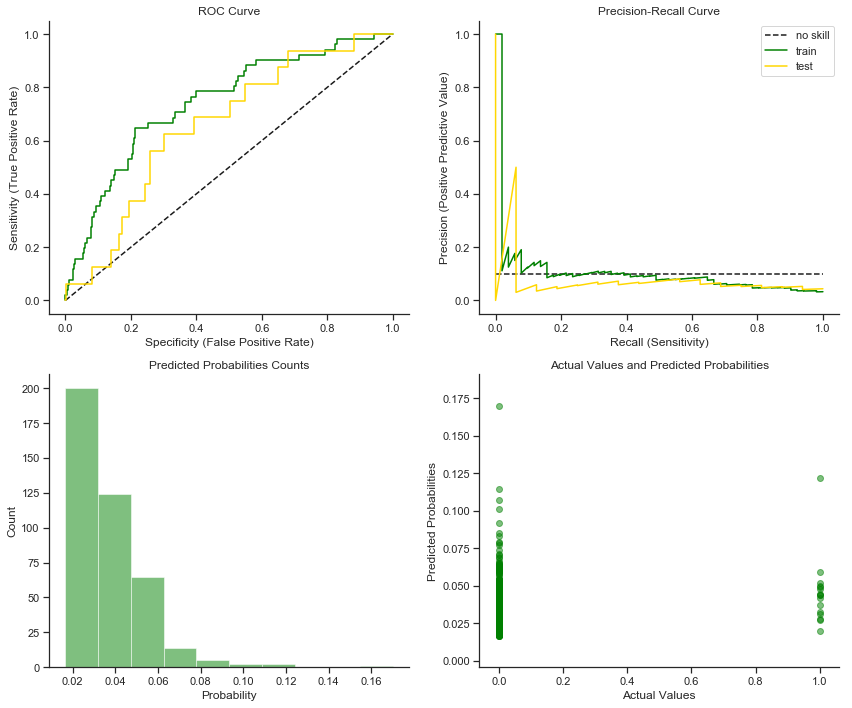

In [10]:
logreg = LogisticRegression(solver='liblinear',
                            penalty='l1',
                            C=0.1,
                            max_iter=1000)

print_metrics(logreg, X_train_cdf, X_test_cdf, y_train, y_test)

Although, random forest and xgboost classifiers are robust with high dimensionalty, selecting fewer features might improve model and reduce overfitting. Use logistic regression with L1 (Lasso) penalty for feature selection.

In [11]:
coefs = logreg.coef_.tolist()
coefs_list = list(zip(X_train_cdf.columns, coefs[0]))
coefs_sorted = sorted(coefs_list, key= lambda x: abs(x[1]), reverse=True)
coefs_sorted[:20]

[('x45_Slow', -0.5075618488929677),
 ('x19_No', -0.5036675931684242),
 ('x16_No', -0.47907550100039625),
 ('x25_1', -0.34353803274277894),
 ('x38_None', -0.3015302570649114),
 ('x6_No', -0.18811091076954856),
 ('x47_None', -0.11622865916175615),
 ('Precipitation (Minimum)', 0.05166921638592656),
 ('x13_Porous', -0.040287942475017824),
 ('x29_No', -0.03378036864197284),
 ('Height, Mature (feet)', -0.026881017913685735),
 ('x34_Low', -0.022918354462371348),
 ('x1_Perennial', -0.022015892367638613),
 ('pH (Maximum)', 0.008074495490664154),
 ('x22_No', -0.0020807923165964064),
 ('x0_Dicot', 0.0),
 ('x0_Gymnosperm', 0.0),
 ('x0_Monocot', 0.0),
 ('x0_Other', 0.0),
 ('x1_Annual', 0.0)]

Appears to be breaking point at 0 for coefficients. Subset data to columns with significant coefficients.

In [12]:
X_train_coef = X_train_cdf.copy()
X_test_coef = X_test_cdf.copy()
top_coefs = [x[0] for x in coefs_sorted if abs(x[1]) > 0]
X_train_coefs = X_train_cdf[top_coefs]
X_test_coefs = X_test_cdf[top_coefs]

Try random forest classifier. Also hypertune parameters with grid search.

In [13]:
params = {'max_depth': [1, 2, 3, 5],
          'min_samples_leaf': [1, 2, 5],
          'min_samples_split': [2, 5, 10],
          'max_features': ['auto','log2', 1, 2],
          'max_leaf_nodes': [None, 2, 3, 5]}

grdsrc = GridSearchCV(RandomForestClassifier(criterion='gini',
                                             n_estimators=100),
                      param_grid=params,
                      cv=5)

grdsrc.fit(X_train_coefs, y_train)

grdsrc.best_params_

{'max_depth': 1,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2}


 Train 
 F1 Score:  0.15 
 Average Precision:  0.127 
 AUC:  0.12 

 Confusion Matrix:  
 [[1221  378]
 [  16   35]] 

 Test 
 F1 Score:  0.13 
 Average Precision:  0.12 
 AUC:  0.097 

 Confusion Matrix:  
 [[316  81]
 [  9   7]] 




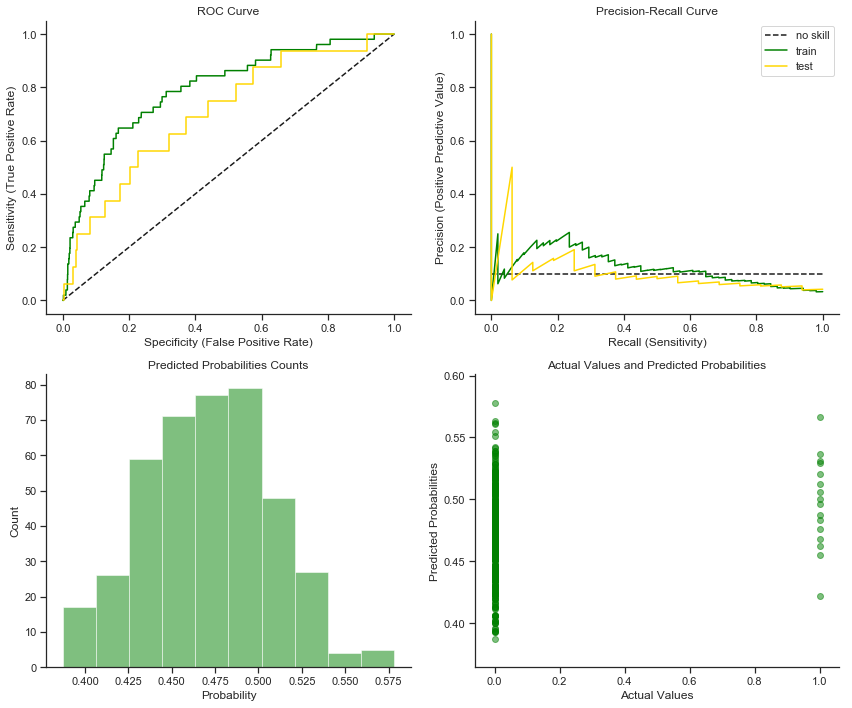

In [14]:
rfc = RandomForestClassifier(n_estimators=1000,
                             criterion='gini',
                             max_depth=1, min_samples_leaf=1,
                             min_samples_split=2, max_features='auto', 
                             max_leaf_nodes=None, class_weight='balanced')

print_metrics(rfc, X_train_coefs, X_test_coefs, y_train, y_test)

Try random forest on entire dataset.

In [15]:
params = {'max_depth': [1, 2, 3, 5],
          'min_samples_leaf': [1, 2, 5],
          'min_samples_split': [2, 5, 10],
          'max_features': ['auto','log2', 1, 2],
          'max_leaf_nodes': [None, 2, 3, 5]}

grdsrc = GridSearchCV(RandomForestClassifier(criterion='gini',
                                             n_estimators=100),
                      param_grid=params,
                      cv=5)

grdsrc.fit(X_train_coefs, y_train)

grdsrc.best_params_

{'max_depth': 1,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2}


 Train 
 F1 Score:  0.21 
 Average Precision:  0.272 
 AUC:  0.26 

 Confusion Matrix:  
 [[1379  220]
 [  19   32]] 

 Test 
 F1 Score:  0.2 
 Average Precision:  0.183 
 AUC:  0.172 

 Confusion Matrix:  
 [[350  47]
 [  9   7]] 




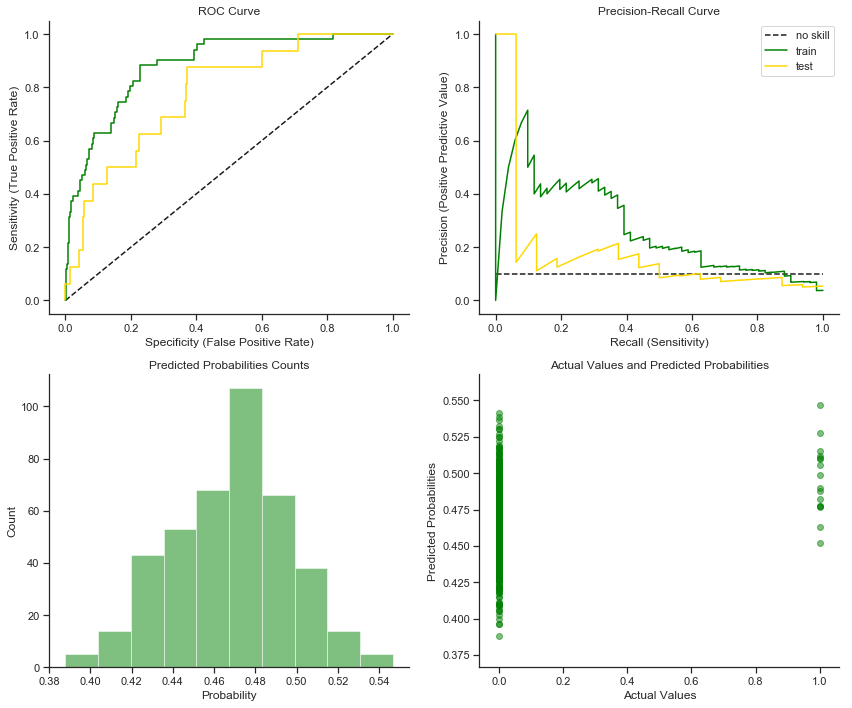

In [16]:
rfc2 = RandomForestClassifier(n_estimators=1000,
                             criterion='gini',
                             max_depth=1, min_samples_leaf=1,
                             min_samples_split=2, max_features='auto', 
                             max_leaf_nodes=None, class_weight='balanced')

print_metrics(rfc, X_train_cdf, X_test_cdf, y_train, y_test)
# ap=.18, auc=.172, ap=.225, auc=.211

Try xgboost classifier with hypertuned parameters from grid search.

In [17]:
params = {'learning_rate': [0.1, 0.2, 0.01, 0.001],
         'max_depth': [1, 2, 3, 4, 5],
         'scale_pos_weight': [1, 2, 3, 30]}
grdsrc = GridSearchCV(XGBClassifier(n_estimators=100),
                      param_grid=params,
                      cv=5)

grdsrc.fit(X_train_cdf, y_train)

grdsrc.best_params_

/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'learning_rate': 0.1, 'max_depth': 1, 'scale_pos_weight': 1}


 Train 
 F1 Score:  0.16 
 Average Precision:  0.205 
 AUC:  0.205 

 Confusion Matrix:  
 [[1148  451]
 [   8   43]] 

 Test 
 F1 Score:  0.14 
 Average Precision:  0.076 
 AUC:  0.067 

 Confusion Matrix:  
 [[292 105]
 [  7   9]] 




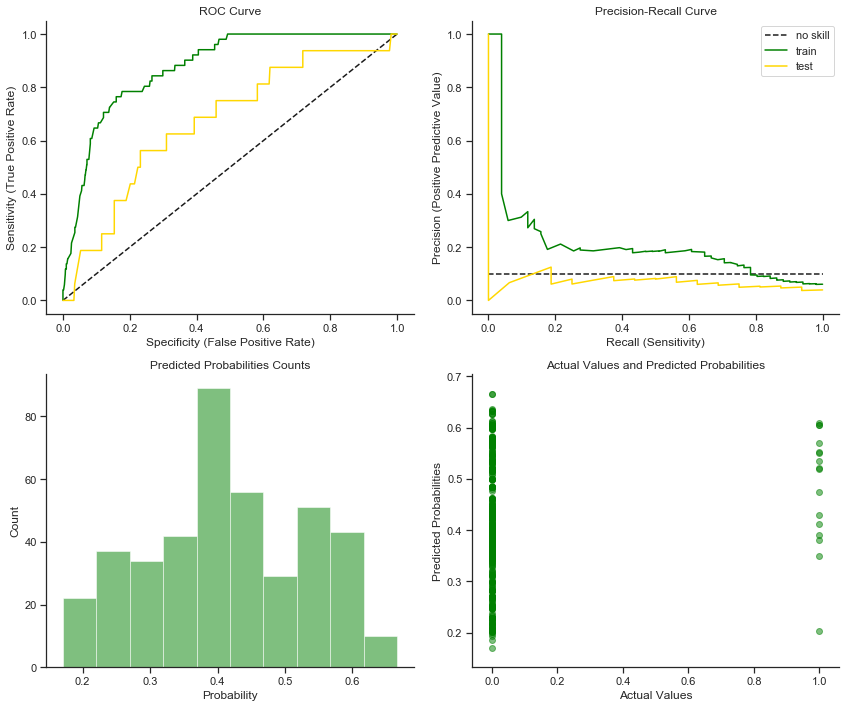

In [18]:
xgb = XGBClassifier(n_estimators=1000,
                    max_depth=3,
                    scale_pos_weight=30,
                    learning_rate=0.001)

print_metrics(xgb, X_train_coefs, X_test_coefs, y_train, y_test)

And try on entire dataset.

In [19]:
params = {'learning_rate': [0.1, 0.2, 0.01, 0.001],
         'max_depth': [1, 2, 3, 4, 5],
         'scale_pos_weight': [1, 2, 3, 30]}
grdsrc = GridSearchCV(XGBClassifier(n_estimators=100),
                      param_grid=params,
                      cv=5)

grdsrc.fit(X_train_cdf, y_train)

grdsrc.best_params_

/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'learning_rate': 0.1, 'max_depth': 1, 'scale_pos_weight': 1}


 Train 
 F1 Score:  0.18 
 Average Precision:  0.206 
 AUC:  0.208 

 Confusion Matrix:  
 [[1187  412]
 [   6   45]] 

 Test 
 F1 Score:  0.15 
 Average Precision:  0.151 
 AUC:  0.13 

 Confusion Matrix:  
 [[303  94]
 [  7   9]] 




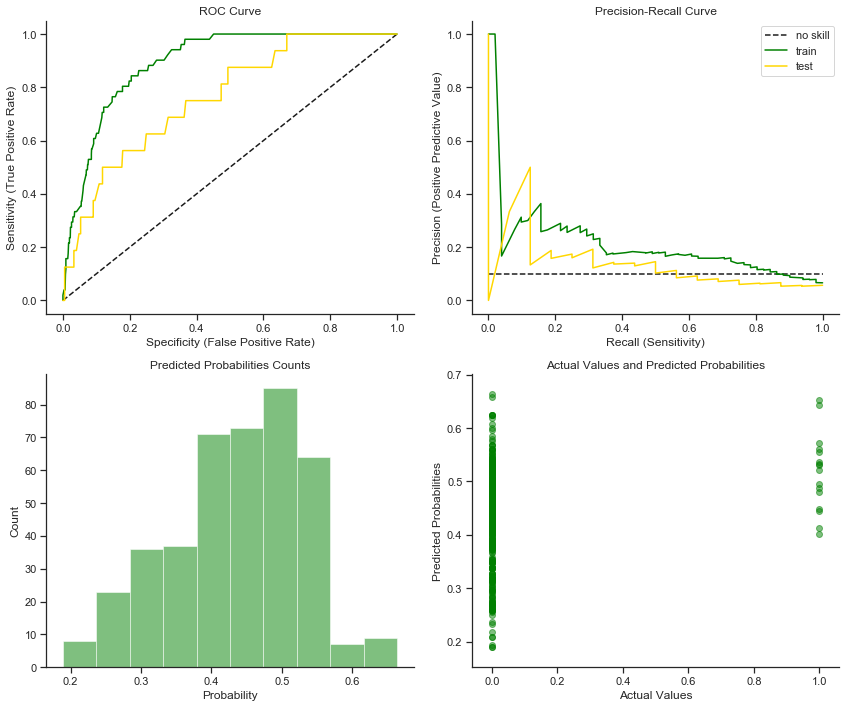

In [20]:
xgb = XGBClassifier(n_estimators=1000,
                    max_depth=2,
                    scale_pos_weight=30,
                    learning_rate=0.001)

print_metrics(xgb, X_train_cdf, X_test_cdf, y_train, y_test)

## SMOTE and Random Over Sampling

we try Random Forests with SMOTE and Random Over Sampling fit both with the best training coefficients and also on all features

In [21]:
ss = SMOTE(sampling_strategy='minority')
X_ss_res, y_ss_res = ss.fit_resample(X_train_coefs, y_train)
              
rs = RandomOverSampler(sampling_strategy='minority')
X_rs_res, y_rs_res = rs.fit_resample(X_train_coefs, y_train)


 Train 
 F1 Score:  0.8 
 Average Precision:  0.883 
 AUC:  0.878 

 Confusion Matrix:  
 [[1265  334]
 [ 307 1292]] 

 Test 
 F1 Score:  0.16 
 Average Precision:  0.115 
 AUC:  0.092 

 Confusion Matrix:  
 [[309  88]
 [  7   9]] 




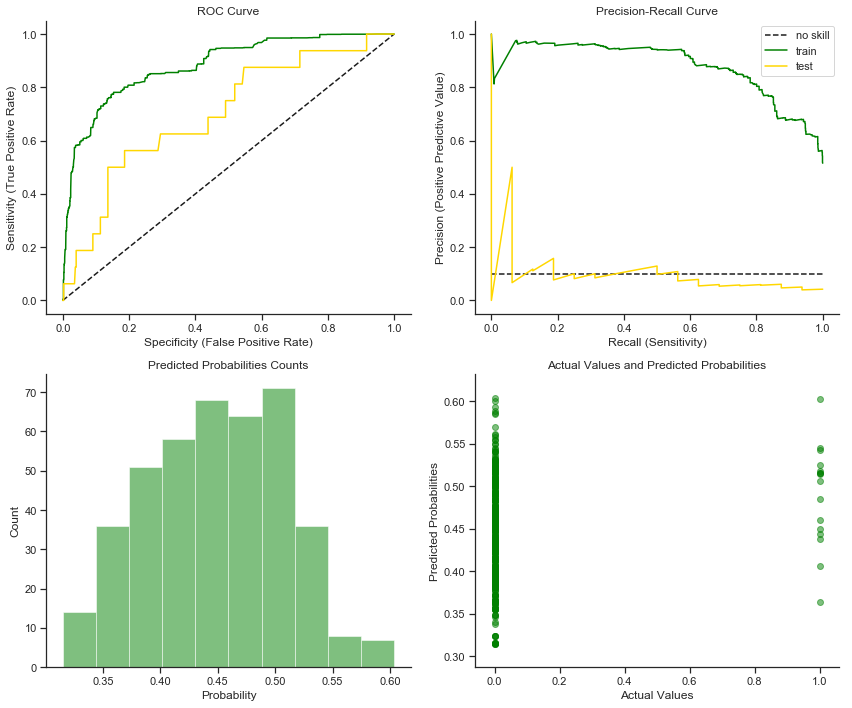

In [22]:
rfc_ss = RandomForestClassifier(n_estimators=1000,
                             criterion='gini',
                             max_depth=1, min_samples_leaf=1,
                             min_samples_split=2, max_features='auto', 
                             max_leaf_nodes=None, class_weight='balanced')

print_metrics(rfc_ss, X_ss_res, X_test_coefs, y_ss_res, y_test)



 Train 
 F1 Score:  0.75 
 Average Precision:  0.762 
 AUC:  0.749 

 Confusion Matrix:  
 [[1119  480]
 [ 361 1238]] 

 Test 
 F1 Score:  0.12 
 Average Precision:  0.09 
 AUC:  0.074 

 Confusion Matrix:  
 [[278 119]
 [  7   9]] 




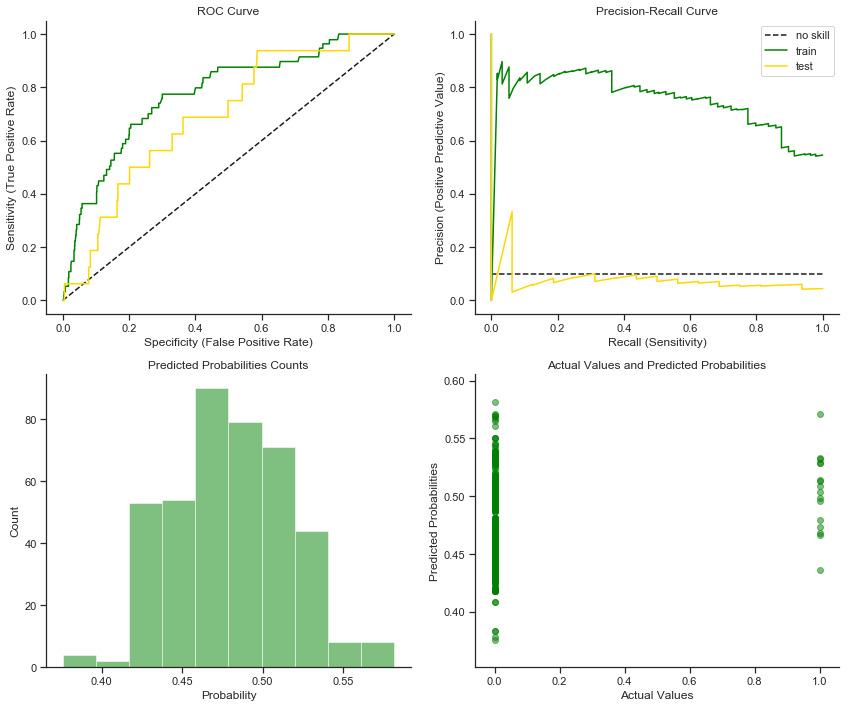

In [23]:
rfc_ss = RandomForestClassifier(n_estimators=1000,
                             criterion='gini',
                             max_depth=1, min_samples_leaf=1,
                             min_samples_split=2, max_features='auto', 
                             max_leaf_nodes=None, class_weight='balanced')

print_metrics(rfc_ss, X_rs_res, X_test_coefs, y_rs_res, y_test)

In [24]:
ss = SMOTE(sampling_strategy='minority')
X_ss_res, y_ss_res = ss.fit_resample(X_train_cdf, y_train)
              
rs = RandomOverSampler(sampling_strategy='minority')
X_rs_res, y_rs_res = rs.fit_resample(X_train_cdf, y_train)


 Train 
 F1 Score:  0.89 
 Average Precision:  0.961 
 AUC:  0.961 

 Confusion Matrix:  
 [[1390  209]
 [ 159 1440]] 

 Test 
 F1 Score:  0.22 
 Average Precision:  0.176 
 AUC:  0.154 

 Confusion Matrix:  
 [[355  42]
 [  9   7]] 




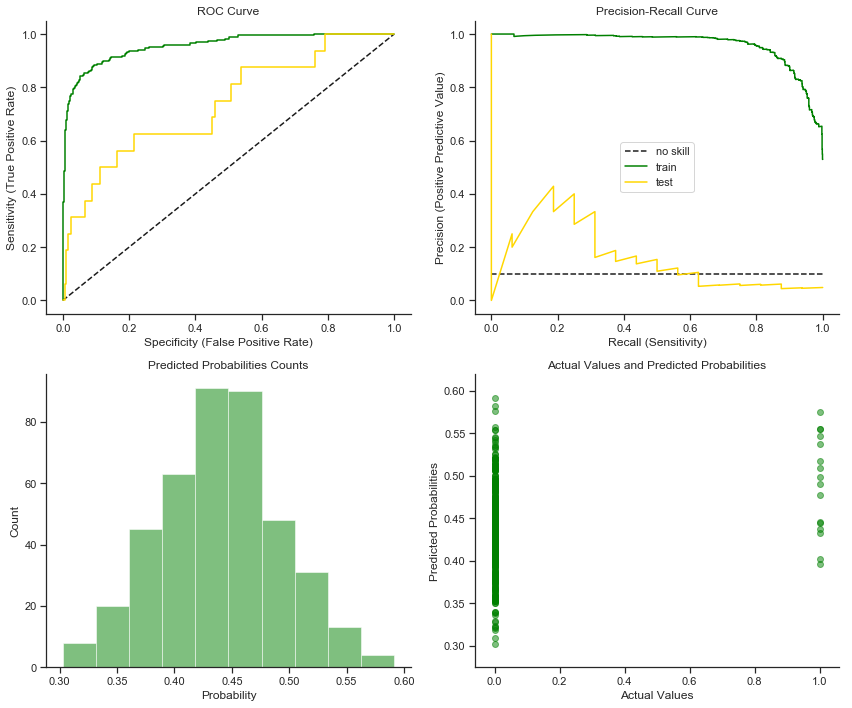

In [25]:
rfc_ss = RandomForestClassifier(n_estimators=1000,
                             criterion='gini',
                             max_depth=1, min_samples_leaf=1,
                             min_samples_split=2, max_features='auto', 
                             max_leaf_nodes=None, class_weight='balanced')

print_metrics(rfc_ss, X_ss_res, X_test_cdf, y_ss_res, y_test)


 Train 
 F1 Score:  0.81 
 Average Precision:  0.852 
 AUC:  0.85 

 Confusion Matrix:  
 [[1174  425]
 [ 219 1380]] 

 Test 
 F1 Score:  0.13 
 Average Precision:  0.189 
 AUC:  0.177 

 Confusion Matrix:  
 [[286 111]
 [  7   9]] 




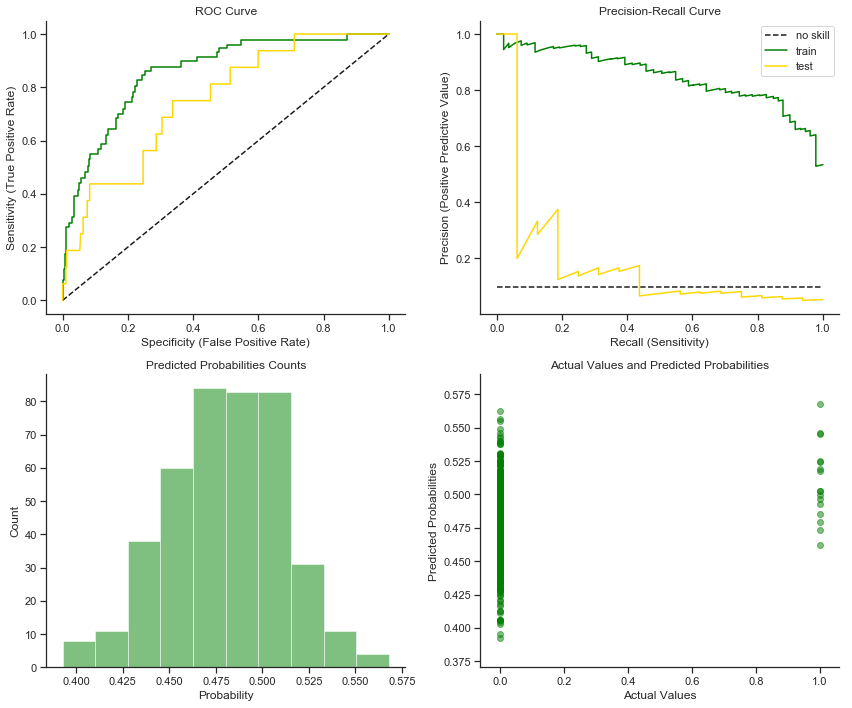

In [26]:
rfc_ss = RandomForestClassifier(n_estimators=1000,
                             criterion='gini',
                             max_depth=1, min_samples_leaf=1,
                             min_samples_split=2, max_features='auto', 
                             max_leaf_nodes=None, class_weight='balanced')

print_metrics(rfc_ss, X_rs_res, X_test_cdf, y_rs_res, y_test)

SMOTE resampling and Random Oversampling appear to have inconsequential results on our Random Forests.

In conclusion, none of our models successfully predict whether or not a plant species is invasive.